In [6]:
import requests
import json
from datetime import datetime
import pandas as pd
from functools import lru_cache

In [7]:
@lru_cache(maxsize=800)
def query2yr(ticker):
  endpoint = 'https://api.tdameritrade.com/v1/marketdata/{stock_ticker}/pricehistory?periodType={periodType}&period={period}&frequencyType={frequencyType}&frequency={frequency}'
  full_url = endpoint.format(stock_ticker=ticker, periodType='year', period=2, frequencyType='daily', frequency=1)
  page = requests.get(url=full_url,
                    params={'apikey' :<get your own API key>}) # goto https://developer.tdameritrade.com/ to create your own app and request a new token
  return json.loads(page.content)

In [68]:
from dateutil.parser import parse as date_parse

def stock_df(ticker, start_date="2020-03-20"):
  stock_data_json = query2yr(ticker)
  start = date_parse(start_date)
  i = next(i for i,r in enumerate(stock_data_json['candles']) if datetime.fromtimestamp(r['datetime']/1000)>=start)
  spy = []
  for r in stock_data_json['candles'][i:]:
    _date = datetime.fromtimestamp(r['datetime']/1000)
    closing_price = float(r['close'])
    spy.append((_date, closing_price))
  return pd.DataFrame(spy, columns=['Date', 'Price'])

## Computing the Absolute Low levels of each Month

In [ ]:
def compute_monthly_lows(spy_df):
  spy_monthly_low_df = spy_df.groupby(['month'])['Price'].min()
  return spy_df.join(spy_monthly_low_df, on='month', rsuffix='_lowest_in_this_month')

def get_monthly_lows(spydf):
  return spydf[spydf["Price"] == spydf["Price_lowest_in_this_month"]]

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
def annotate_date(plt, x, y):
  y_offset = -50
  if x.day > 15:
     y_offset*=-1
  plt.annotate(x.strftime("%b %d"), (x, y), 
                   xytext=(x, y+y_offset),
                   arrowprops = dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))

def plot_monthly_lows(ticker, cond = lambda x: True):
  spy_df = stock_df(ticker)
  spy_df['month'] = spy_df['Date'].apply(lambda d: d.year*100 + d.month)
  spy_df = compute_monthly_lows(spy_df)
  monthly_lows1 = get_monthly_lows(spy_df)
  fig = plt.figure(figsize=(21, 3))
  ax = fig.add_subplot(111)
  spy_df.plot(y='Price',x= 'Date', title= ticker +" monthly lows", ax=ax)
  monthly_lows_date = []
  monthly_lows_price = []
  for _, r in monthly_lows1[["Date","Price","month"]].iterrows():
    if cond(r):
      x = r["Date"]
      y = r["Price"]
      annotate_date(plt, x, y)
      monthly_lows_date.append(x)
      monthly_lows_price.append(y)
  plt.scatter(monthly_lows_date,monthly_lows_price,s=80)
  plt.show()

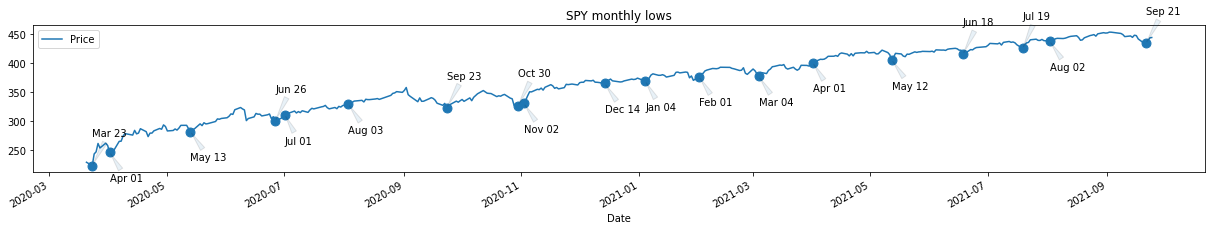

In [77]:
plot_monthly_lows("SPY", lambda r: r['Date'] > date_parse("2020-03-20"))

In [12]:
def is_3rd_week(dateobj):
  """slightly expanded definition of 3rd week of the month"""
  day = dateobj.day
  if day < 25 and day > 14:
    return True
  return False

In [9]:
spy_df = stock_df("SPY")

In [37]:
spy_df['month'] = spy_df['Date'].apply(lambda d: d.year*100 + d.month)

## Computing the low levels of 3rd week each Month

In [15]:
def compute_monthly_lows2(spy_df):
  spy_monthly_low_df = spy_df.groupby(['month','is_3d_week'])['Price'].min()
  return spy_df.join(spy_monthly_low_df, on='month', rsuffix='_low_in_this_month')

def get_monthly_lows2(spydf):
  return spydf[spydf["Price"] == spydf["Price_low_in_this_month"]]

In [13]:
spy_df['is_3d_week'] = spy_df['Date'].apply(is_3rd_week)

In [33]:
spy_monthly_low_df = spy_df.groupby(['month','is_3d_week'])['Price'].min()
price = list(spy_monthly_low_df)

In [43]:
monthly_lows2=dict([(year, price[i]) for i,(year, is_3rd_week) in enumerate(spy_monthly_low_df.index) if is_3rd_week])

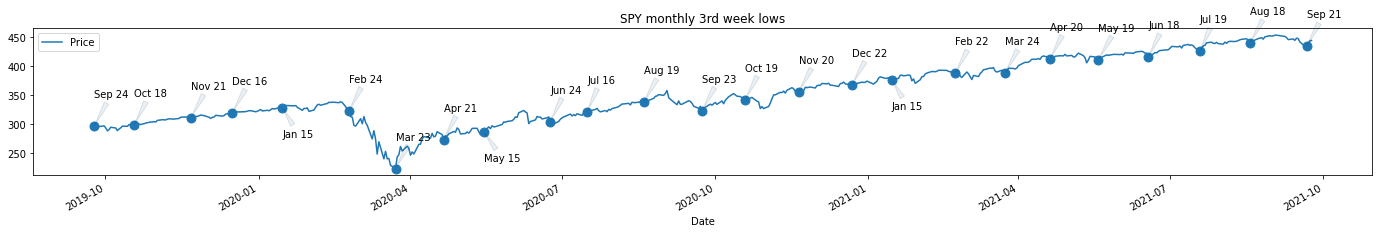

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(24, 3))
ax = fig.add_subplot(111)
spy_df.plot(y='Price',x= 'Date', title= "SPY monthly 3rd week lows", ax=ax)
week2_lows_date = []
week2_lows_price = []
for _,r in spy_df.iterrows():
    month = r["month"]
    if r["Price"] == monthly_lows2[month]:
      annotate_date(plt, r["Date"], r["Price"])
      week2_lows_date.append(r["Date"])
      week2_lows_price.append(r["Price"])

plt.scatter(week2_lows_date,week2_lows_price,s=80, )
plt.show()

### Plotting instances where the absolute monthly lows occurr in the 3rd week

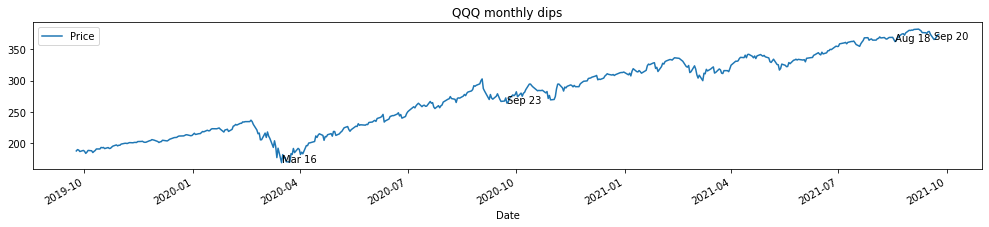

In [ ]:
plot_monthly_lows("QQQ", is_3rd_week)

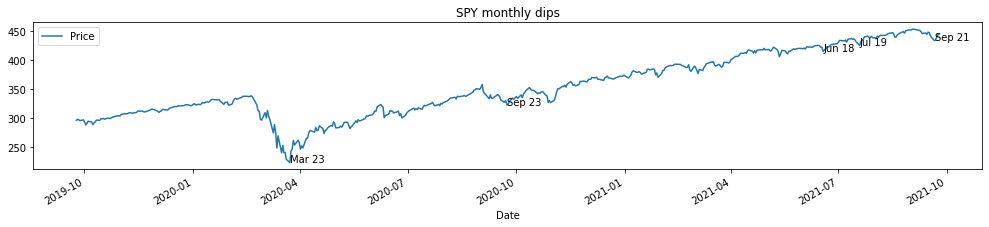

In [ ]:
plot_monthly_lows("SPY",is_3rd_week)

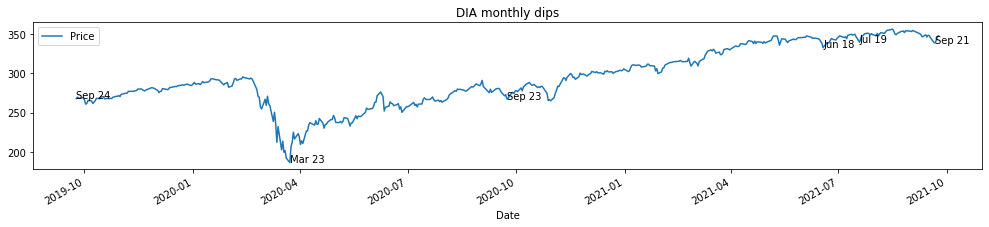

In [ ]:
plot_monthly_lows("DIA",is_3rd_week)